## **Setup**

In [1]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wHuSnwal690wEVPxNXt9uQrMH4wkDimmnGZ7vgnPJS1qVm_nNerZLc
Mounted at /content/gdrive/


In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
!pip install utils
from utils import *

     |████████████████████████████████| 727kB 9.5MB/s 
     |████████████████████████████████| 358kB 45.3MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 1.0MB 41.4MB/s 
     |████████████████████████████████| 40kB 6.3MB/s 
     |████████████████████████████████| 92kB 11.6MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 2.6MB 48.7MB/s 


In [3]:
from fastai.vision.all import *

In [4]:
import os
import shutil
import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz
from zipfile import ZipFile
from tempfile import TemporaryDirectory
from PIL import Image

import cv2
from google.colab.patches import cv2_imshow
import imutils
from scipy.optimize import minimize_scalar

from sklearn.metrics import f1_score, accuracy_score

# plot options
# plt.rcParams.update({'font.size': 11})
plt.style.use('fivethirtyeight')

In [6]:
# Set and test path to competition data files
competition_path = 'My Drive/AI For Good - AI Blitz 3/Sudoku/Data/'
model_path = 'My Drive/AI For Good - AI Blitz 3/Sudoku/Models/'
filename = 'train.tar'
assert(os.path.exists(f'{mount_path}/{competition_path}/train.tar'))
print('Drive mounted correctly and data accessible')

Drive mounted correctly and data accessible


# Functions

In [7]:
def sqdif(bingray,sq,ang):
  rsq=imutils.resize(imutils.rotate_bound(sq,ang),width=bingray.shape[0],height=bingray.shape[0])

  return np.sum(np.abs(bingray-rsq))

In [8]:
def derotate(img):
  sq=np.ones(img.shape)*255
  imsz = img.shape[0]

  # binarize by blurring then using Otsu's method
  # blur=cv2.GaussianBlur(gray,(1,1),0)
  _,bingray = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  rotang=minimize_scalar(lambda ang: sqdif(bingray,sq,ang),
                         bounds=[-45,45], method='Bounded').x

  if rotang<0:
    triang=np.tan(np.pi/4+rotang*np.pi/180)
    act_x=imsz/2*(1+triang)
    act_y=imsz/2*(1-triang)

    pts1 = np.float32([[0,act_y],[act_x,0],[imsz-act_x,imsz],[imsz,imsz-act_y]])

  else:
    triang=np.tan(np.pi/4-rotang*np.pi/180)
    act_x=imsz/2*(1-triang)
    act_y=imsz/2*(1+triang)

    pts1 = np.float32([[act_x,0],[imsz,imsz-act_y],[0,act_y],[imsz-act_x,imsz]])

  pts2 = np.float32([[0,0],[imsz,0],[0,imsz],[imsz,imsz]])
  M = cv2.getPerspectiveTransform(pts1,pts2)
  
  return cv2.warpPerspective(img,M,(imsz,imsz))

In [19]:
# SUDOKU SOLVING ALGORITHM BY PETER NORVIG https://norvig.com/sudoku.html
# slightly modified by Benjamin P Isaacoff on 8/29/20
# original code (pre-modification by BPI) taken from https://github.com/Adityaojas/sudoku-solver/blob/master/norvig.py

def cross(A, B):
  "Cross product of elements in A and elements in B."
  return [a+b for a in A for b in B]
    
digits   = '123456789'
rows     = 'ABCDEFGHI'
cols     = digits
squares  = cross(rows, cols)
unitlist = ([cross(rows, c) for c in cols] +
        [cross(r, cols) for r in rows] +
        [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')])
units = dict((s, [u for u in unitlist if s in u]) 
         for s in squares)
peers = dict((s, set(sum(units[s],[]))-set([s]))
         for s in squares)


def test():
  "A set of unit tests."
  assert len(squares) == 81
  assert len(unitlist) == 27
  assert np.all(len(units[s]) == 3 for s in squares)
  assert np.all(len(peers[s]) == 20 for s in squares)
  assert units['C2'] == [['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2'],
                          ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'],
                          ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3']]
  assert peers['C2'] == set(['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2',
                              'C1', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
                              'A1', 'A3', 'B1', 'B3'])
  print('All tests pass.')


def parse_grid(grid):
  """Convert grid to a dict of possible values, {square: digits}, or
  return False if a contradiction is detected."""
  ## To start, every square can be any digit; then assign values from the grid.
  values = dict([(s, digits) for s in squares])
  for s,d in list(grid_values(grid).items()):
      if d in digits and not assign(values, s, d):
          return False ## (Fail if we can't assign d to square s.)
  return values

def grid_values(grid):
  "Convert grid into a dict of {square: char} with '0' or '.' for empties."
  chars = [c for c in grid if c in digits or c in '0.']
  assert len(chars) == 81
  return dict(list(zip(squares, chars)))


def assign(values, s, d):
  """Eliminate all the other values (except d) from values[s] and propagate.
  Return values, except return False if a contradiction is detected."""
  other_values = values[s].replace(d, '')
  if np.all([eliminate(values, s, d2) for d2 in other_values]):
      return values
  else:
      return False

def eliminate(values, s, d):
  """Eliminate d from values[s]; propagate when values or places <= 2.
  Return values, except return False if a contradiction is detected."""
  if d not in values[s]:
      return values ## Already eliminated
  values[s] = values[s].replace(d,'')
  ## (1) If a square s is reduced to one value d2, then eliminate d2 from the peers.
  if len(values[s]) == 0:
    return False ## Contradiction: removed last value
  elif len(values[s]) == 1:
      d2 = values[s]
      if not np.all([eliminate(values, s2, d2) for s2 in peers[s]]):
          return False
  ## (2) If a unit u is reduced to only one place for a value d, then put it there.
  for u in units[s]:
    dplaces = [s for s in u if d in values[s]]
    if len(dplaces) == 0:
        return False ## Contradiction: no place for this value
    elif len(dplaces) == 1:
        # d can only be in one place in unit; assign it there
          if not assign(values, dplaces[0], d):
              return False
  return values

def sudoku_display(instr):
  for rowind in range(9):
    rowstr=[]
    for colind in range(9):
      rowstr.append(str(instr[9*rowind+colind]))
      if colind==2 or colind==5: rowstr.append('|')
    print(' '.join(rowstr))

    if rowind==2 or rowind==5:
      print('---------------------')
  print(' ')
    
def solve(grid):
  return search(parse_grid(grid))


def search(values):
  "Using depth-first search and propagation, try all possible values."
  if values is False:
      # print('False here 000')
      return False ## Failed earlier
  if np.all([len(values[s]) == 1 for s in squares]): 
      return values ## Solved!
  ## Chose the unfilled square s with the fewest possibilities
  n,s = min([(len(values[s]), s) for s in squares if len(values[s]) > 1])
  return some([search(assign(values.copy(), s, d)) for d in values[s]])

def some(seq):
  "Return some element of seq that is true."
  for e in seq:
      if e: return e
  return False


#solve("400000805030000000000700000020000060000080400000010000000603070500200000104000000")
#solve([0, 0, 0, 0, 0, 0, 8, 1, 8, 0, 0, 0, 2, 3, 0, 0, 0, 6, 0, 0, 5, 7, 0, 0, 1, 0, 7, 0, 9, 6, 0, 0, 0, 0, 0, 9, 0, 7, 0, 4, 0, 1, 0, 0, 0, 0, 0, 8, 1, 0, 4, 0, 6, 0, 0, 2, 4, 0, 0, 8, 0, 0, 4, 5, 0, 0, 9, 3, 5, 0, 0, 0, 0, 0, 0])

#parse_grid("4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......")

# Load the digit training images and train the learner

# Load Sudoku Data

In [10]:
home_dir='/content/All_Data/'
# this can take a bit (maybe 30s)
# All_Data is the home directory for the images, from which training and validation splits will be taken
if not os.path.exists(home_dir):
  os.mkdir(home_dir)
  shutil.unpack_archive(f'{mount_path}/{competition_path}/train.tar',home_dir)  

In [11]:
imgs=glob.glob('/content/All_Data/train/images/*.png')

In [12]:
solutions=pd.read_csv('/content/All_Data/train/labels.csv')

In [13]:
learn=load_learner(f'{mount_path}{model_path}200906_1150_fullgennums.pkl')

In [14]:
labeldict={0:'1',1:'2',2:'3',3:'4',4:'5',5:'6',6:'7',7:'8',8:'9',9:'.'}

tmpdir='imgs4solv/'
# this can take a bit (maybe 30s)
# All_Data is the home directory for the images, from which training and validation splits will be taken
if not os.path.exists(f'{home_dir}{tmpdir}'):
  os.mkdir(f'{home_dir}{tmpdir}')

In [17]:
def extractNsolve(impath):
  imid=os.path.basename(impath)[:-4]  

  solstr=solutions.loc[int(imid),'solution']

  img=cv2.imread(impath)
  # convert the image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imsz = gray.shape[0]
  # derotate
  img=derotate(gray)

  # segment the image and write to file
  for rowind in range(9):
      for colind in range(9):
        subimg=img[(rowind*int(imsz/9)):((rowind+1)*int(imsz/9)),
                  (colind*int(imsz/9)):((colind+1)*int(imsz/9))]
        # convert to PIL and write to file
        # NOTE: converting to PIL to match the generating script
        Image.fromarray(subimg).save(f'{home_dir}{tmpdir}{rowind}{colind}.png')

  test_imgs=get_image_files(f'{home_dir}{tmpdir}')
  # sorting alphabetically works due to the naming structure in the loop above
  test_imgs.sort()  

  attempt_cntr=0
  failedsolve=True
  while failedsolve:
    attempt_cntr+=1

    tst_dl=learn.dls.test_dl(test_imgs)

    learn.epoch=0
    preds = learn.tta(dl=tst_dl,n=10)[0]

    ### Attempt straightforward solution ###
    curgrid=pd.Series(torch.argmax(preds,dim=1).numpy()).map(labeldict)
    curgrid=''.join(curgrid)

    try:
      solved=solve(curgrid)
      solved_grid=''.join(solved.values())

      # failedsolve = False          
      return solved_grid
    except:
      print('Solving failed for '+impath)
    
    if attempt_cntr>=5:
      print('Giving up on '+impath)
      return 'sudontku'

In [20]:
np.random.shuffle(imgs)

solved_df=[]
solvdict={'id':None,'solved_grid':None}
for ind,impath in enumerate(imgs):
  imid=os.path.basename(impath)[:-4]

  print(imid)

  solvdict['id']=imid
  solvdict['solved_grid']=extractNsolve(impath)

  solved_df.append(solvdict.copy())

2364


0066


2310


3194


0334


2718


3022


1227


2628


1306


1296


4616


4114


3877


4670


0469


4197


3249


1796


1716


1005


4278


2898


3252


3853


3711


2693


4116


4837


0567


1903


3189


3700


2161


4282


4185


3980


3888


4637


3766


4785


2902


3148


1055


0104


4872


4322


0387


0718


3941


0619


2832


0359


4686


4507


0654


4804


4840


2509


1475


3126


4985


2238


2624


2074


0509


3930


0871


1908


2186


2814


2989


Solving failed for /content/All_Data/train/images/2989.png


1088


3335


2312


4935


1248


4601


1561


4917


3543


1674


3667


0994


1933


3540


0216


4767


2485


3479


1419


0556


2041


2456


3931


4678


2979


KeyboardInterrupt: ignored

In [21]:
solved_df=pd.DataFrame(solved_df)

In [22]:
corgrid=[]
for _,currow in solved_df.iterrows():
  if currow['solved_grid']==solutions.loc[solutions['id']==int(currow['id']),'solution'].values[0]:
    corgrid.append(1)
  else:
    corgrid.append(0)

In [23]:
corgrid=np.array(corgrid)

In [25]:
np.mean(corgrid)

0.9270833333333334

In [24]:
np.where(corgrid==0)[0]

array([19, 45, 52, 64, 73, 83, 89])

In [38]:
solved_df.loc[np.where(corgrid==0)[0],'id']

3     4847
19    3312
28    1864
30    1966
Name: id, dtype: object

# Start Working Cells

In [15]:
impath='/content/All_Data/train/images/3313.png'

In [16]:
# def extractNsolve(impath):
imid=os.path.basename(impath)[:-4]  

solstr=solutions.loc[int(imid),'solution']

img=cv2.imread(impath)
# convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imsz = gray.shape[0]
# derotate
img=derotate(gray)

# segment the image and write to file
for rowind in range(9):
    for colind in range(9):
      subimg=img[(rowind*int(imsz/9)):((rowind+1)*int(imsz/9)),
                (colind*int(imsz/9)):((colind+1)*int(imsz/9))]
      # convert to PIL and write to file
      # NOTE: converting to PIL to match the generating script
      Image.fromarray(subimg).save(f'{home_dir}{tmpdir}{rowind}{colind}.png')

test_imgs=get_image_files(f'{home_dir}{tmpdir}')
# sorting alphabetically works due to the naming structure in the loop above
test_imgs.sort()

tst_dl=learn.dls.test_dl(test_imgs)

attempt_cntr=0
failedsolve=True
while failedsolve:
  attempt_cntr+=1

  learn.epoch=0
  preds = learn.tta(dl=tst_dl,n=10)[0]

  ### Attempt straightforward solution ###
  curgrid=pd.Series(torch.argmax(preds,dim=1).numpy()).map(labeldict)
  curgrid=''.join(curgrid)

  # try:
  solved=solve(curgrid)
  solved_grid=''.join(solved.values())

  failedsolve = False
        
    # return solved_grid
  # except:
  #   print('Solving failed for '+impath)
  
  if attempt_cntr>=5:
    print('Giving up on '+impath)
    # return 'sudontku'

False here 000


AttributeError: ignored

In [66]:
try:
    solved=solve(curgrid)
    solved_grid=''.join(solved.values())

    failedsolve = False
        
    # return solved_grid
except:
  print('Solving failed for '+impath)


False here 000
Solving failed for /content/All_Data/train/images/3313.png


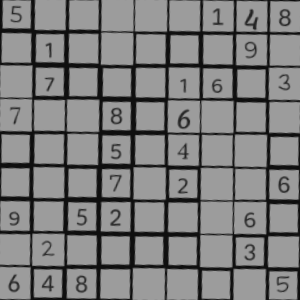

5 . . | . . . | 1 4 8
. 1 . | . . . | . 9 .
. 7 . | . . 1 | 6 . 3
---------------------
7 . . | 8 . 6 | . . .
. . . | 5 . 4 | . . .
. . . | 7 . 2 | . . 6
---------------------
9 . 5 | 2 . . | . 6 .
. 2 . | . . . | . 3 .
6 4 8 | . . . | . . 5
 
5 6 9 | 3 2 7 | 1 4 8
8 1 3 | 4 6 5 | 2 9 7
4 7 2 | 9 8 1 | 6 5 3
---------------------
7 9 4 | 8 3 6 | 5 1 2
2 8 6 | 5 1 4 | 3 7 9
3 5 1 | 7 9 2 | 4 8 6
---------------------
9 3 5 | 2 4 8 | 7 6 1
1 2 7 | 6 5 9 | 8 3 4
6 4 8 | 1 7 3 | 9 2 5
 


In [55]:
solstr=solutions.loc[int(imid),'solution']


cv2_imshow(img)

sudoku_display(curgrid)
sudoku_display(solstr)

In [62]:
solved=solve(curgrid)

In [63]:
solved_grid=''.join(solved.values())

AttributeError: ignored

In [64]:
solved

False

# End Working Cells

/content/All_Data/imgs4solv/82.png


('5', tensor(4), tensor([4.3608e-04, 1.9152e-04, 7.8117e-02, 4.7378e-04, 9.2052e-01, 4.4181e-06, 2.9699e-05, 2.4759e-05, 1.8557e-04, 1.5480e-05]))


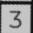

In [ ]:
# curfname=test_imgs[-1]
curfname='/content/All_Data/imgs4solv/82.png'
print(curfname)
print(learn.predict(curfname))
cv2_imshow(cv2.imread(str(curfname)))

# End working cells

# Solution loop

In [ ]:
def extractNsolve(impath):

  imid=os.path.basename(impath)[:-4]    

  solstr=solutions.loc[int(imid),'solution']

  img=cv2.imread(impath)
  # convert the image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imsz = gray.shape[0]
  # derotate
  img=derotate(gray)
  
  # segment the image and write to file
  for rowind in range(9):
      for colind in range(9):
        subimg=img[(rowind*int(imsz/9)):((rowind+1)*int(imsz/9)),
                  (colind*int(imsz/9)):((colind+1)*int(imsz/9))]
        # convert to PIL and write to file
        # NOTE: converting to PIL to match the generating script
        Image.fromarray(subimg).save(f'{home_dir}{tmpdir}{rowind}{colind}.png')

  test_imgs=get_image_files(f'{home_dir}{tmpdir}')
  # sorting alphabetically works due to the naming structure in the loop above
  test_imgs.sort()

  tst_dl=learn.dls.test_dl(test_imgs)
  preds = learn.get_preds(dl=tst_dl, inner=True)[0];

  ### Attempt straightforward solution ###
  curgrid=pd.Series(torch.argmax(preds,dim=1).numpy()).map(labeldict)
  curgrid=''.join(curgrid)

  try:
    solved=solve(curgrid)
    solved_grid=''.join(solved.values())

    # print('Sudoku grid solved correctly: '+str(solved_grid==solstr))
    # return curgrid, solved_grid
    return solved_grid
  except:
    print('Solving failed for '+impath)

    return 'sudont'

In [ ]:
solved_df=[]
solvdict={'id':None,'solved_grid':None}
for ind,impath in enumerate(imgs):
  print(ind)
  
  imid=os.path.basename(impath)[:-4]

  solvdict['id']=imid
  solvdict['solved_grid']=extractNsolve(impath)

  solved_df.append(solvdict.copy())

In [ ]:
solved_df=pd.DataFrame(solved_df)

In [ ]:
corgrid=[]
for _,currow in solved_df.iterrows():
  if currow['solved_grid']==solutions.loc[solutions['id']==int(currow['id']),'solution'].values[0]:
    corgrid.append(1)
  else:
    corgrid.append(0)

In [ ]:
np.mean(corgrid)

0.8939828080229226

In [ ]:
currow['solved_grid']==solutions.loc[solutions['id']==int(currow['id']),'solution'].values[0]

True

In [ ]:
solutions['id']

0          0
1          1
2          2
3          3
4          4
        ... 
4995    4995
4996    4996
4997    4997
4998    4998
4999    4999
Name: id, Length: 5000, dtype: int64

# working cells


/content/All_Data/train/images/1379.png
1379


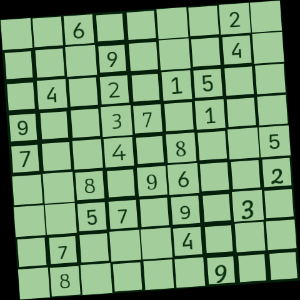

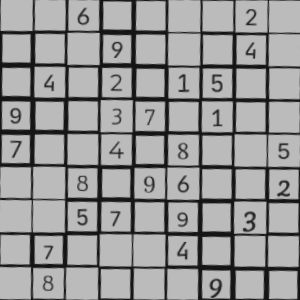

In [ ]:
impath=np.random.choice(imgs)
print(impath)
imid=os.path.basename(impath)[:-4]
print(imid)

solstr=solutions.loc[int(imid),'solution']

img=cv2.imread(impath)
cv2_imshow(img)

# convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imsz = gray.shape[0]


img=derotate(gray)

cv2_imshow(img)


In [ ]:
labeldict={0:'1',1:'2',2:'3',3:'4',4:'5',5:'6',6:'7',7:'8',8:'9',9:'.'}

tmpdir='imgs4solv/'
# this can take a bit (maybe 30s)
# All_Data is the home directory for the images, from which training and validation splits will be taken
if not os.path.exists(f'{home_dir}{tmpdir}'):
  os.mkdir(f'{home_dir}{tmpdir}')

# segment the image and write to file
for rowind in range(9):
    for colind in range(9):
      subimg=img[(rowind*int(imsz/9)):((rowind+1)*int(imsz/9)),
                 (colind*int(imsz/9)):((colind+1)*int(imsz/9))]
      # convert to PIL and write to file
      # NOTE: converting to PIL to match the generating script
      Image.fromarray(subimg).save(f'{home_dir}{tmpdir}{rowind}{colind}.png')

test_imgs=get_image_files(f'{home_dir}{tmpdir}')
# sorting alphabetically works due to the naming structure in the loop above
test_imgs.sort()

tst_dl=learn.dls.test_dl(test_imgs)
preds = learn.get_preds(dl=tst_dl,inner=True)[0];

### Attempt straightforward solution ###
curgrid=pd.Series(torch.argmax(preds,dim=1).numpy()).map(labeldict)
curgrid=''.join(curgrid)

try:
  solved=solve(curgrid)
  solved_grid=''.join(solved.values())

  print('Sudoku grid solved correctly: '+str(solved_grid==solstr))
  # return curgrid, solved_grid
except:
  print('Solving failed')
  



Sudoku grid solved correctly: True


In [ ]:
preds = learn.tta(dl=tst_dl)

epoch,train_loss,valid_loss,accuracy,time


AttributeError: ignored

In [ ]:
sudoku_display(curgrid)
sudoku_display(solstr)

. . . | . . 8 | . . .
. . 2 | . . . | 1 5 7
. . . | 7 1 . | . 6 .
---------------------
8 . . | . . 5 | . 3 .
2 7 . | 3 . 1 | . 4 9
. 3 . | 9 . . | . . 1
---------------------
. 6 . | . 5 3 | . . .
9 2 8 | . . . | 3 . .
. . . | 3 . . | . . .
 
7 1 6 | 5 2 8 | 4 9 3
4 8 2 | 6 3 9 | 1 5 7
3 5 9 | 7 1 4 | 2 6 8
---------------------
8 9 1 | 4 6 5 | 7 3 2
2 7 5 | 3 8 1 | 6 4 9
6 3 4 | 9 7 2 | 5 8 1
---------------------
1 6 7 | 8 5 3 | 9 2 4
9 2 8 | 1 4 6 | 3 7 5
5 4 3 | 2 9 7 | 8 1 6
 


In [ ]:
# curfname=test_imgs[-1]
curfname='/content/All_Data/imgs4solv/83.png'
print(curfname)
learn.predict(curfname)

/content/All_Data/imgs4solv/83.png


('3',
 tensor(2),
 tensor([6.2624e-05, 8.1759e-03, 9.9144e-01, 2.3893e-05, 1.5271e-04, 3.9480e-06, 2.7283e-05, 2.1099e-05, 8.2167e-05, 8.7729e-06]))

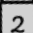

In [ ]:
# curfname=test_imgs[-1]
curfname='/content/All_Data/imgs4solv/83.png'
print(curfname)
learn.predict(curfname)
cv2_imshow(cv2.imread(str(curfname)))

In [ ]:
  asd=preds.numpy().copy()

In [ ]:
asd.shape

(81, 10)

In [ ]:
for predrow in range(81):
  currow=asd[predrow,:]
  if np.sum(currow/np.max(currow)>1e-3)>=2:
    print(currow)

[9.98553455e-01 1.45246458e-05 1.13931565e-05 1.71128049e-04 4.84011025e-06 2.53580693e-05 1.13925477e-03 2.66665097e-06 1.34854258e-06 7.58871538e-05]
[6.2624429e-05 8.1758713e-03 9.9144155e-01 2.3892577e-05 1.5270954e-04 3.9480260e-06 2.7282691e-05 2.1099344e-05 8.2167440e-05 8.7728640e-06]


In [ ]:
predrow=75
currow=asd[predrow,:]

In [ ]:
np.any(currow/np.max(currow)>1e-3)

True

In [ ]:
currow[np.argmax(currow)]=0

In [ ]:
np.argmax(currow)

1